#  DTI-derived metrics (FA, MD, AD, RD) within FS-segmented ROIs

BMED360-2021  `05-dmr-dti-feature-extraction-roi-wise.ipynb`

(assuming the `02-dmri-find-affine-fs-brainmask2dwi.ipynb` and `03-dmri-reconstruction-dti.ipynb` and `04-dmri-do-affine-reg-anat2dwi.ipynb` notebooks have been executed)

<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab3-diffusion-MRI/05-dmr-dti-feature-extraction-roi-wise.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Learning objectives



#### Check [FreeSurferColorLUT.txt](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT)  for the ROI-label for the different regions (left and right hemisphere)


Relevant ROIs:
```
# Below is the color table for a lobar white matter parcelation
#  obtained from running
# mri_annotation2label --subject subject --hemi lh --lobesStrict lobes
# mri_annotation2label --subject subject --hemi rh --lobesStrict lobes
# mri_aparc2aseg --s subject --labelwm --hypo-as-wm --rip-unknown \
#   --volmask --o wmparc.lobes.mgz --ctxseg aparc+aseg.mgz \
#   --annot lobes --base-offset 200 [--base-offset must be last arg]

3201    wm-lh-frontal-lobe                  235 35  95  0
3203    wm-lh-cingulate-lobe                35  75  35  0
3204    wm-lh-occiptal-lobe                 135 155 195 0
3205    wm-lh-temporal-lobe                 115 35  35  0
3206    wm-lh-parietal-lobe                 35  195 35  0
3207    wm-lh-insula-lobe                   20  220 160 0

4201    wm-rh-frontal-lobe                  235 35  95  0
4203    wm-rh-cingulate-lobe                35  75  35  0
4204    wm-rh-occiptal-lobe                 135 155 195 0
4205    wm-rh-temporal-lobe                 115 35  35  0
4206    wm-rh-parietal-lobe                 35  195 35  0
4207    wm-rh-insula-lobe                   20  220 160 0
```


### For using Colab
**--> (some of) the following libraries must be `pip installed` (i.e. uncommet these among the following pip commands):**

In [1]:
#!pip install gdown
#!pip install nilearn
#!pip install dipy

**Download a data file from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [2]:
import gdown
import shutil
import sys
import os
from os.path import expanduser, join, basename, split
import glob
import shutil
import platform

Check your platform for running this notebook

In [3]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:14 PST 2021; root:xnu-7195.101.1~3/RELEASE_X86_64)


In [4]:
cwd = os.getcwd()

In [5]:
working_dir = join(cwd, 'data')
bids_dir = '%s/bids_bg_bmed360' % (working_dir)
dmri_res = '%s/dmri_results' % (working_dir)

In [6]:
# Download zip-file if ./data does not exist (as when running in Colab)

if os.path.isdir(working_dir) == False:
    
    ## Download data.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already!')

./data  exists already!


In [7]:
# Download zip-file if ./data/dmri_results does not exist (as when running in Colab)

if os.path.isdir(dmri_res) == False:
    
    ## Download dmri_results.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1wu5pzAcE2hyZymq-IzuzKYGK_lMYbnJy'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = 'dmri_results.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data/dmri_results`
    shutil.unpack_archive(output, './data/')
    
    ## Delete the `dmri_results.zip` file
    os.remove(output)
else:
    print(f'./data/dmri_results  exists already!')

./data/dmri_results  exists already!


## Import libraries

In [8]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from os.path import expanduser, join, basename, split
import time
from dipy.io.image import save_nifti

In [9]:
def get_dti_features_from_roi(inpdir, sub, ses, roi_name, roi_num, outdir):
    r"""
    Extraction of DTI-derived featurevalues, i.e. FA, MD, AD, RD from a given antomical region, named 'roi_name'
    and numbered by Freesurfer as 'roi_num' with respect to the coregistered wmparc segmented image for 
    given subject ('sub') and session ('ses' = 1) 

    Parameters
    ----------
    inpdir     : input directory e.g. inpdir = 'data/dmri_results' where the moving files 
                   from Freesurfer segmentation mapped to T1w native space are stored.
    sub        : subject id, e.g. 102 for sub-102
    ses        : session number, e.g. 1 for ses-1
    roi_name   : name of a (white matter) region in wmparc, e.g. 'wm-lh-insula'
    roi_num    : number of that region according to the Freesurfer LUT, e.g. 3035
    outdir     : output directory e.g. outdir = inpdir, where resulting ... are stored,

    Returns
    -------
    meas_name  : list of DTI-derived features, for now ['fa', 'md', 'ad', 'rd']
    meas_num   : number of voxels in the named 3D ROI region (same accross all features)
    meas_val   : the feature values of each feature i in ['fa', 'md', 'ad', 'rd']


    Notes
    -----

    """
    
    # Preparations
    
    # Load WMPARC: 
    wmparc_fn = join(inpdir, 'sub_%d_tp%d_wmparc_in_native_space_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))
    wmparc_img= nib.load(wmparc_fn)
    wmparc_data = wmparc_img.get_fdata()
    wmparc_affine = wmparc_img.affine
    
    #a = wmparc_data.flatten()
    #unique, counts = np.unique(a, return_counts=True)
    #dict(zip(unique, counts))
    
    roi = np.where(wmparc_data == roi_num)
    roi_flatten = np.where(wmparc_data.flatten() == roi_num)
    
    # Metrics from DTI in native DWI space
    dti_metrics = ['fa', 'md', 'ad', 'rd']
    meas_name = []
    meas_num = []
    meas_val = []
    for i, meas in enumerate(dti_metrics):
        fname = join(inpdir, 'sub_%d_tp%d_dwi_brainmask_tensor_%s.nii.gz' % (sub, ses, meas))
        meas_img= nib.load(fname)
        meas_data = meas_img.get_fdata()
        meas_affine = meas_img.affine
        
        meas_data_flatten = meas_data.flatten()
        
        meas_name.append(meas)
        meas_num.append(len(roi_flatten[0]))
        meas_val.append(meas_data_flatten[roi_flatten])
        
        #plt.hist(meas_val[i],bins=50)
        #plt.title('sub-%d | %s | %s | n=%d' % (sub, roi_name, meas_name[i], len(roi_flatten[0])))
        #plt.show()
        
    
    #fig = plt.figure(figsize = [14, 12])
    #for i, meas in enumerate(dti_metrics):
    #    plt.subplot(2,2,i+1)
    #    plt.hist(meas_val[i],bins=50, color='black')
    #    plt.title('sub-%d | %s | %s | n=%d | median=%.5f' %
    #              (sub, roi_name, meas_name[i].upper(), len(roi_flatten[0]), np.median(meas_val[i])))
    #plt.show()
    #fig.savefig('%s/tmp/FIGURES/sub_%d_wmparc_%s_dti_features.png' % (home, sub, roi_name),
    #       transparent=False, dpi=300, bbox_inches="tight")
    
    return dti_metrics, meas_name, meas_num, meas_val


In [10]:
# get_dti_features_from_roi?

In [11]:
inp_dir = dmri_res 
outp_dir = inp_dir

### Test the function

In [12]:
roi_name = 'wm-lh-insula'
roi_num = 3035
sub = 102
ses = 1

In [13]:
%%time
dti_metrics, meas_name, meas_num, meas_val = \
get_dti_features_from_roi(inp_dir, sub, ses, roi_name, roi_num, outp_dir)

CPU times: user 88 ms, sys: 24.1 ms, total: 112 ms
Wall time: 111 ms


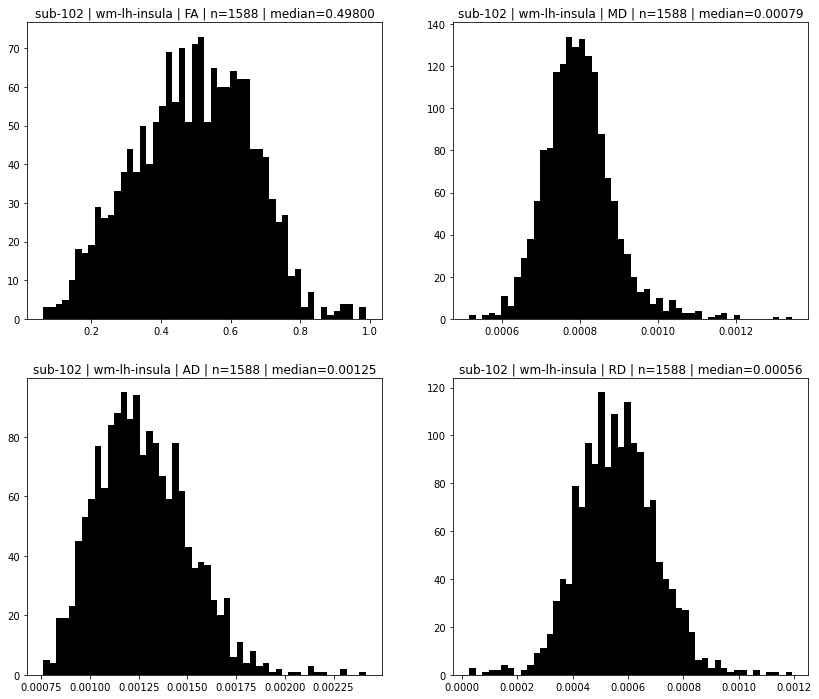

In [14]:
fig = plt.figure(figsize = [14, 12])
for i, meas in enumerate(dti_metrics):
    plt.subplot(2,2,i+1)
    plt.hist(meas_val[i],bins=50, color='black')
    plt.title('sub-%d | %s | %s | n=%d | median=%.5f' %
                  (sub, roi_name, meas_name[i].upper(), len(meas_val[i]), np.median(meas_val[i])))
plt.show()
#fig.savefig('./assets/sub_%d_wmparc_%s_dti_features.png' % (sub, roi_name),
#           transparent=False, dpi=300, bbox_inches="tight")

## Run for all subjects

In [15]:
# Relevant WM regions:

rois = [3035, 4035, 10, 49, 13, 52]
wm_dict = {3035: 'wm-lh-insula', 
           4035: 'wm-rh-insula',
             10: 'Left-Thalamus-Proper',
             49: 'Right-Thalamus-Proper',
             13: 'Left-Pallidum',
             52: 'Right-Pallidum'}
wm_dict[rois[0]], wm_dict[rois[-1]]

('wm-lh-insula', 'Right-Pallidum')

```python
# Mechanism to save dictionaries and lists as a binary .npy file
import numpy as np

# Save
dictionary = {'hello':'world'}
np.save('%s/tmp/my_file.npy' % (home), dictionary) 

# Load
read_dictionary = np.load('%s/tmp/my_file.npy' % (home),allow_pickle='TRUE').item()
print(read_dictionary['hello']) # displays "world"
```
--> 
world

In [16]:
%%time

ses=1

for j in range(len(rois)):
    roi_num = rois[j]
    roi_name = wm_dict[rois[j]]

    dic = {}
    dipy_dic = []
    
    for sub in [102, 103, 111, 123]:
        print(f'Computing sub:{sub} ses:{ses} roi:{roi_name}')
        dti_metrics, meas_name, meas_num, meas_val = \
            get_dti_features_from_roi(inp_dir, sub, ses, roi_name, roi_num, outp_dir)
        dic = {'subj': sub, 'roi_num': roi_num, 'roi_name': roi_name, \
               'meas_name': meas_name, 'meas_num': meas_num, 'meas_val': meas_val}
        dipy_dic.append(dic)
        
    # np.save('%s/%s_%d_dipy_dic.npy' % (outp_dir, roi_name, roi_num), dipy_dic) 
    np.save('%s/%s_%d_dipy_dic.npy' % (outp_dir, roi_name, roi_num), dipy_dic)

Computing sub:102 ses:1 roi:wm-lh-insula
Computing sub:103 ses:1 roi:wm-lh-insula
Computing sub:111 ses:1 roi:wm-lh-insula
Computing sub:123 ses:1 roi:wm-lh-insula
Computing sub:102 ses:1 roi:wm-rh-insula
Computing sub:103 ses:1 roi:wm-rh-insula
Computing sub:111 ses:1 roi:wm-rh-insula
Computing sub:123 ses:1 roi:wm-rh-insula
Computing sub:102 ses:1 roi:Left-Thalamus-Proper
Computing sub:103 ses:1 roi:Left-Thalamus-Proper
Computing sub:111 ses:1 roi:Left-Thalamus-Proper
Computing sub:123 ses:1 roi:Left-Thalamus-Proper
Computing sub:102 ses:1 roi:Right-Thalamus-Proper
Computing sub:103 ses:1 roi:Right-Thalamus-Proper
Computing sub:111 ses:1 roi:Right-Thalamus-Proper
Computing sub:123 ses:1 roi:Right-Thalamus-Proper
Computing sub:102 ses:1 roi:Left-Pallidum
Computing sub:103 ses:1 roi:Left-Pallidum
Computing sub:111 ses:1 roi:Left-Pallidum
Computing sub:123 ses:1 roi:Left-Pallidum
Computing sub:102 ses:1 roi:Right-Pallidum
Computing sub:103 ses:1 roi:Right-Pallidum
Computing sub:111 ses:

In [17]:
# Load

for j in range(len(rois)):
    roi_num = rois[j]
    roi_name = wm_dict[rois[j]]
    read_dipy_dic = np.load('%s/%s_%d_dipy_dic.npy' % (outp_dir, roi_name, roi_num), allow_pickle='TRUE')
    
    print('ROI #%d: %s %d' % (j, wm_dict[rois[j]], rois[j]))
    print('- Subject', read_dipy_dic[0]['subj']) # displays 101
    print('-', read_dipy_dic[0]['meas_name'][0]) # displays fa
    print('-', read_dipy_dic[0]['meas_num'][0]) # displays number of voxels in region
    print('-', read_dipy_dic[0]['meas_val'][0]) # displays FA vector of length number of voxels in region
    print('-', read_dipy_dic[0]['meas_val'][0].mean().round(4)) # displays mean value of FA vector in region
    print('.....')
    print('- Subject', read_dipy_dic[-1]['subj']) # displays 130
    print('-', read_dipy_dic[-1]['meas_name'][0]) # displays fa
    print('-', read_dipy_dic[-1]['meas_num'][0]) # displays number of voxels in region
    print('-', read_dipy_dic[-1]['meas_val'][0]) # displays FA vector of length number of voxels in region
    print('-', read_dipy_dic[-1]['meas_val'][0].mean().round(4)) # displays mean value of FA vector in region

ROI #0: wm-lh-insula 3035
- Subject 102
- fa
- 1588
- [0.4070451  0.34805855 0.42998108 ... 0.24451551 0.37719929 0.25275582]
- 0.4911
.....
- Subject 123
- fa
- 1289
- [0.19441648 0.29957369 0.2641407  ... 0.10999358 0.06014513 0.26261741]
- 0.3884
ROI #1: wm-rh-insula 4035
- Subject 102
- fa
- 1625
- [0.56532001 0.5257057  0.64456826 ... 0.56478226 0.77072507 0.43658444]
- 0.4731
.....
- Subject 123
- fa
- 1201
- [0.39496666 0.52496779 0.41189063 ... 0.45212981 0.35864359 0.3720012 ]
- 0.4219
ROI #2: Left-Thalamus-Proper 10
- Subject 102
- fa
- 1414
- [0.19165075 0.19245476 0.2609424  ... 0.65007341 0.46091723 0.54429221]
- 0.372
.....
- Subject 123
- fa
- 1053
- [0.1215516  0.23493798 0.14775026 ... 0.30583057 0.51805598 0.35059491]
- 0.3062
ROI #3: Right-Thalamus-Proper 49
- Subject 102
- fa
- 1344
- [0.36227742 0.70933825 0.82158417 ... 0.16002595 0.2186504  0.23473842]
- 0.3512
.....
- Subject 123
- fa
- 822
- [0.65006459 0.5366962  0.62918907 0.3700721  0.43630597 0.38011476
 0.